<a href="https://colab.research.google.com/github/sooolee/Udacity/blob/main/1_Udacity_P2_RN50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
# Define transforms
## YOUR CODE HERE ##
train_transform = T.Compose([T.RandomRotation(45),
                             T.RandomVerticalFlip(p=0.3),
                             T.Resize(224),
                             T.ToTensor(),
                             T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])])

test_transform = T.Compose([T.Resize(224),
                            T.ToTensor(),
                            T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])])

# Create training set and define training dataloader
## YOUR CODE HERE ##
import torchvision.datasets as datasets

trainset = datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Create test set and define test dataloader
## YOUR CODE HERE ##
testset = datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=False, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /root/.pytorch/CIFAR10_data/cifar-10-python.tar.gz to /root/.pytorch/CIFAR10_data/
Files already downloaded and verified


In [ ]:
# def show5(img_loader):
#     dataiter = iter(img_loader)
    
#     batch = next(dataiter)
#     labels = batch[1][0:5]
#     images = batch[0][0:5]
#     for i in range(5):
#         print(classes[labels[i]])
    
#         image = images[i].numpy()
#         std = [0.247, 0.243, 0.261] 
#         mean = [0.491, 0.482, 0.447]
#         for j in range(3):
#             image[j] = std[j] * images[i][j] + mean[j]
#         plt.imshow(np.rot90(image.T, k=3))
#         plt.show()

In [ ]:
# show5(trainloader)

In [ ]:
## YOUR CODE HERE ##
from torchvision import models

model = models.resnet50(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
for param in model.parameters():
    param.requires_grad = True
    
model.fc = nn.Sequential(nn.Linear(2048, 1024),
                         nn.ReLU(),
                         nn.Dropout(0.2),
                         nn.Linear(1024, 512),
                         nn.ReLU(),
                         nn.Dropout(0.2),
                         nn.Linear(512, 128),
                         nn.ReLU(),
                         nn.Dropout(0.2),
                         nn.Linear(128, 10),
                         nn.LogSoftmax(dim=1))

In [ ]:
## YOUR CODE HERE ##
criterion = nn.NLLLoss()

params_group = [{'params': model.layer1.parameters(), 'lr': 0.0001},
                {'params': model.layer2.parameters(), 'lr': 0.0001},
                {'params': model.layer3.parameters(), 'lr': 0.0001}, 
                {'params': model.layer4.parameters(), 'lr': 0.0001},
                {'params': model.fc.parameters(), 'lr': 0.0005}]
optimizer = optim.Adam(params_group)

#optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

In [ ]:
## YOUR CODE HERE ##
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device);

In [ ]:
epochs = 5
steps = 0
train_loss = 0
print_every = 20

train_losses, test_losses, accuracies = [], [], []

for epoch in range(epochs):  
  for images, labels in trainloader:
      steps += 1
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()
      output = model.forward(images)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()
      
      train_loss += loss.item()
      
      if steps % print_every == 0:
          test_loss = 0
          accuracy = 0
          model.eval()
          with torch.no_grad():
              for images, labels in testloader:
                  images, labels = images.to(device), labels.to(device)

                  output = model.forward(images)
                  test_loss += criterion(output, labels).item()
                  
                  ps = torch.exp(output)
                  top_p, top_class = ps.topk(1, dim=1)
                  equals = top_class == labels.view(*top_class.shape)
                  accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
          print(f"Epoch {epoch+1}/{epochs}.. "
                f"Train loss: {train_loss/print_every:.3f}.. "
                f"Test loss: {test_loss/len(testloader):.3f}.. "
                f"Test accuracy: {accuracy/len(testloader):.3f}") 
          
          train_losses.append(train_loss/print_every)
          test_losses.append(test_loss/len(testloader))
          accuracies.append(accuracy/len(testloader))
          train_loss=0
          model.train()

Epoch 1/5.. Train loss: 2.182.. Test loss: 1.875.. Test accuracy: 0.252
Epoch 1/5.. Train loss: 1.730.. Test loss: 1.343.. Test accuracy: 0.459
Epoch 1/5.. Train loss: 1.494.. Test loss: 1.021.. Test accuracy: 0.599
Epoch 1/5.. Train loss: 1.297.. Test loss: 0.959.. Test accuracy: 0.645
Epoch 1/5.. Train loss: 1.242.. Test loss: 0.811.. Test accuracy: 0.675
Epoch 1/5.. Train loss: 1.134.. Test loss: 0.767.. Test accuracy: 0.747
Epoch 1/5.. Train loss: 1.065.. Test loss: 0.639.. Test accuracy: 0.783
Epoch 1/5.. Train loss: 0.945.. Test loss: 0.773.. Test accuracy: 0.749
Epoch 1/5.. Train loss: 0.996.. Test loss: 0.664.. Test accuracy: 0.781
Epoch 1/5.. Train loss: 0.939.. Test loss: 0.598.. Test accuracy: 0.808
Epoch 1/5.. Train loss: 0.909.. Test loss: 0.513.. Test accuracy: 0.833
Epoch 1/5.. Train loss: 0.835.. Test loss: 0.541.. Test accuracy: 0.824
Epoch 1/5.. Train loss: 0.913.. Test loss: 0.630.. Test accuracy: 0.792
Epoch 1/5.. Train loss: 0.869.. Test loss: 0.498.. Test accuracy

KeyboardInterrupt: ignored

Text(0, 0.5, 'Losses')

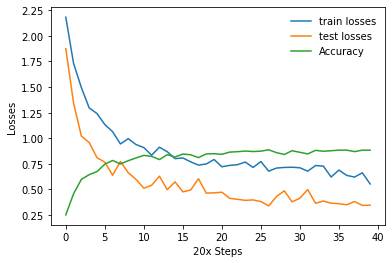

In [ ]:
fig, ax = plt.subplots()
ax.plot(train_losses, label="train losses")
ax.plot(test_losses, label ="test losses")
ax.plot(accuracies, label = "Accuracy")
ax.legend(frameon=False)
ax.set_xlabel('20x Steps')
ax.set_ylabel('Losses')